# **Overview:**

Chương trình này là tiếp nối của chương trình Part-2_Visualization.ipynb

Chương trình là thử nghiệm các mô hình Machine Learning trên tập dữ liệu đã được xử lý cũng như có cái nhìn tổng quan từ 2 phần trước.

# **6. Khai báo và cài đặt cần sử dụng**

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from datetime import datetime
import warnings

In [9]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,9

### **Đọc dữ liệu**

In [10]:
# from google.colab import drive
# drive.mount('data')

In [11]:
df = pd.read_csv('data/newProcessed22.csv')

In [12]:
df

,Index,Domain,Domain_Length,Subdomain_Level,Url_Length,Url_Depth,Have_At_Sign,Have_Tilde_Symbol,No_Https,Having_IP,...,DNS,Domain_Age,Domain_End,Rank_Host,Rank_Country,Iframe,Mouse_Over,Right_Click,Forwarding,Label
0,0,google.com,10,1,43,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,1,google.com,10,1,36,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,2,google.com,10,1,41,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,3,bilnet.eu,9,1,16,0,0,0,1,0,...,0,1,1,1,1,0,0,0,1,0
4,4,bil-privatebanking.eu,21,1,28,0,0,0,1,0,...,0,1,1,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13041,13041,formbuddy.com,13,1,56,2,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
13042,13042,formbuddy.com,13,1,61,2,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
13043,13043,habbocreditosparati.blogspot.com,32,1,44,0,0,0,1,0,...,1,1,1,1,1,0,0,0,0,1
13044,13044,creditiperhabbogratissicuro100.blogspot.com,43,1,95,3,0,0,1,0,...,1,1,1,1,1,0,0,0,0,1


**Kiểm tra độ quan trọng của đăc trưng (feature important)**

In [13]:
df.columns

Index(['Index', 'Domain', 'Domain_Length', 'Subdomain_Level', 'Url_Length',
       'Url_Depth', 'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https',
       'Having_IP', 'Domain_In_Subdomains', 'Domain_In_Paths',
       'Http_In_Hostname', 'Double_Slash_In_Path', 'Num_Dots',
       'Num_Dashes_In_Hostname', 'Num_Underscore', 'Num_Percent',
       'Num_Query_Components', 'Num_Ampersand', 'Num_Hash',
       'Num_Numeric_Chars', 'Path_Length', 'Query_Length',
       'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection', 'Tiny_URL',
       'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End', 'Rank_Host',
       'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click', 'Forwarding',
       'Label'],
      dtype='object')

In [51]:
features = ['Domain_Length', 'Subdomain_Level', 'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https', 'Having_IP', 'Domain_In_Subdomains', 'Domain_In_Paths', 'Http_In_Hostname', 'Double_Slash_In_Path', 'Num_Dots', 'Num_Dashes_In_Hostname', 'Num_Underscore', 'Num_Percent', 'Num_Query_Components', 'Num_Ampersand', 'Num_Hash', 'Num_Numeric_Chars', 'Path_Length', 'Query_Length', 'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection', 'Tiny_URL', 'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End', 'Rank_Host', 'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click', 'Forwarding']

In [15]:
X = df[features]
y = df['Label']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
rf.feature_importances_

array([2.33114309e-01, 0.00000000e+00, 1.43074423e-02, 1.19519672e-03,
       3.42888075e-02, 2.31640581e-04, 2.73613446e-02, 5.87191295e-04,
       3.34609226e-06, 8.54049938e-04, 5.79524197e-02, 3.18551830e-02,
       1.62020882e-02, 5.71879064e-03, 5.88139876e-03, 5.28082944e-03,
       5.29530000e-03, 8.76542217e-02, 1.85459571e-01, 8.34195563e-02,
       1.53811796e-02, 0.00000000e+00, 4.86869131e-03, 1.85701663e-02,
       2.89952999e-02, 8.87817909e-03, 2.81046829e-02, 3.53590027e-02,
       1.76728923e-02, 8.27922157e-03, 9.84095641e-03, 6.95575796e-03,
       9.27777832e-03, 1.11535054e-02])

<BarContainer object of 34 artists>

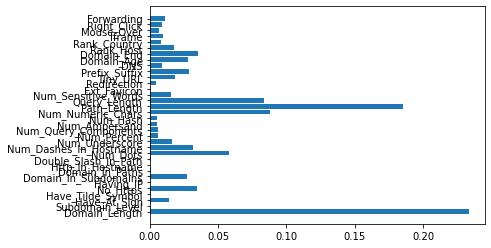

In [50]:
plt.barh(features, rf.feature_importances_)

# **7. Huấn luyện mô hình - Classification**

**Split dataset**

In [53]:
Y = y

In [21]:
from sklearn.model_selection import train_test_split

In [54]:
X_train,X_test,Y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [23]:
print('Kích thước tập huấn luyện: ', X_train.shape, y_train.shape)
print('Kích thước tập kiểm tra: ', X_test.shape, y_test.shape)

Kích thước tập huấn luyện:  (10436, 34) (9132,)
Kích thước tập kiểm tra:  (2610, 34) (2610,)


In [24]:
# Hàm tính độ chính xác, ma trận nhầm lẫn, Recall, precision, f1 score và vẽ đồ thị ROC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def evaluate_model(model, X_test, y_test, y_prediction):
  print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
  #Accuracy
  print("1. Accuracy:",metrics.accuracy_score(y_prediction,y_test))
  # confusion_matrix
  print('2. confusion_matrix:')
  print(confusion_matrix(y_prediction,y_test))
  # recall_score
  print('3. recall_score: ', recall_score(y_prediction,y_test))
  # precision_score
  print('4. precision_score: ', precision_score(y_prediction,y_test))
  # f1_score
  print('5. f1_score: ', f1_score(y_prediction,y_test))
  # ROC plot
  print('6. Biểu đồ ROC của mô hình:')
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.show()

**Logistic Regression**

In [57]:
# #Given smote, we have to do a little adjustment
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score

# logreg = LogisticRegression(fit_intercept=True, penalty='l2')
# logreg.fit(X_train, Y_train)

# logregprediction=logreg.predict(X_test)

# evaluate_model (logreg, X_test, y_test, logregprediction)

**Linear Discriminant Analysis**

In [26]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, Y_train)

# lda_prediction=lda.predict(X_test)

# evaluate_model (lda, X_test, y_test, lda_prediction)

**Gaussian Naive Bayes**

In [27]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# gnb.fit(X_train, Y_train)

# gnbprediction=gnb.predict(X_test)

# evaluate_model (gnb, X_test, y_test, gnbprediction)

**Decision Tree Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8045977011494253
2. confusion_matrix:
[[1034  296]
 [ 214 1066]]
3. recall_score:  0.8328125
4. precision_score:  0.7826725403817915
5. f1_score:  0.8069644208932627
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


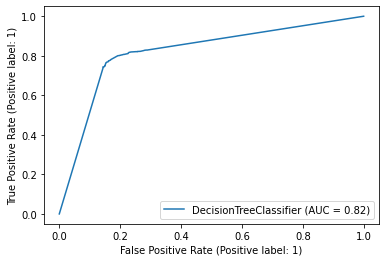

In [61]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier(random_state=72)
dtc.fit(X_train,Y_train)

dtcprediction=dtc.predict(X_test)

evaluate_model (dtc, X_test, y_test, dtcprediction)


**Random Forest Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8371647509578544
2. confusion_matrix:
[[1066  243]
 [ 182 1119]]
3. recall_score:  0.8601076095311299
4. precision_score:  0.8215859030837004
5. f1_score:  0.8404055576417574
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


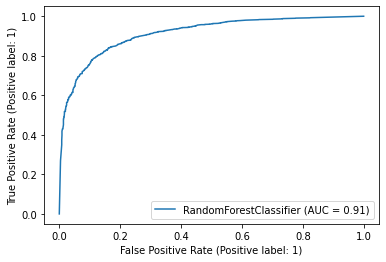

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_jobs=-1,random_state=43)
#learning
rfc.fit(X_train,Y_train)
#Prediction
rfcprediction=rfc.predict(X_test)

evaluate_model (rfc, X_test, y_test, rfcprediction)


**SVM Classifier**

In [30]:
# from sklearn import svm
# #making the instance
# svc = svm.SVC(random_state=123)
# #learning
# svc.fit(X_train,Y_train)
# #Prediction
# svcprediction=svc.predict(X_test)

# evaluate_model (svc, X_test, y_test, svcprediction)

**K-NearestNeighbours Classifier**

In [31]:
# from sklearn.neighbors import KNeighborsClassifier
# #making the instance
# knn = KNeighborsClassifier()
# #learning
# knn.fit(X_train,Y_train)
# #Prediction
# knnprediction=knn.predict(X_test)

# evaluate_model (knn, X_test, y_test, knnprediction)

**Ada Boost**

In [32]:
# from sklearn.ensemble import AdaBoostClassifier

# ada_model = AdaBoostClassifier(n_estimators=200, random_state=44)

# #learning
# ada_model.fit(X_train,Y_train)
# #Prediction
# ada_modelprediction=ada_model.predict(X_test)

# evaluate_model (ada_model, X_test, y_test, ada_modelprediction)

**XGB Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8329501915708812
2. confusion_matrix:
[[1062  250]
 [ 186 1112]]
3. recall_score:  0.8567026194144838
4. precision_score:  0.8164464023494861
5. f1_score:  0.8360902255639098
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


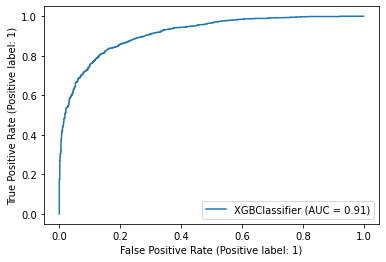

In [33]:
from xgboost import XGBClassifier

XGB_1 = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)

#learning
XGB_1.fit(X_train,Y_train)
#Prediction
XGB_modelprediction=XGB_1.predict(X_test)

evaluate_model (XGB_1, X_test, y_test, XGB_modelprediction)

**XGB Classifier Ver_2**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.831800766283525
2. confusion_matrix:
[[1063  254]
 [ 185 1108]]
3. recall_score:  0.8569218870843001
4. precision_score:  0.8135095447870778
5. f1_score:  0.8346516007532956
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


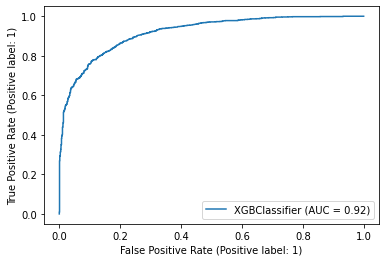

In [34]:
xgb_2 = XGBClassifier(learning_rate=0.4,max_depth=7)
#learning
xgb_2.fit(X_train,Y_train)
#Prediction
xgb_2_modelprediction_v2=xgb_2.predict(X_test)

evaluate_model (xgb_2, X_test, y_test, xgb_2_modelprediction_v2)

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.831800766283525
2. confusion_matrix:
[[1063  254]
 [ 185 1108]]
3. recall_score:  0.8569218870843001
4. precision_score:  0.8135095447870778
5. f1_score:  0.8346516007532956
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


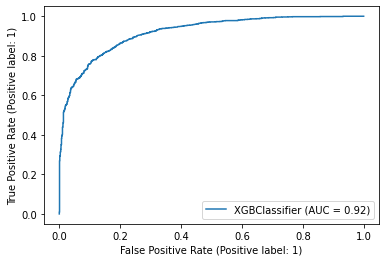

In [35]:
from xgboost import XGBClassifier

# instantiate the model
xgb_3 = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb_3.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_xgb = xgb_3.predict(X_test)

evaluate_model (xgb_3, X_test, y_test, y_test_xgb)

**Light GBM**

In [36]:
# from lightgbm import LGBMClassifier

# lgbm_clf = LGBMClassifier(n_estimators=1000, objective='binary',
#                           class_weight={0:25, 1:1}, learning_rate=0.01,
#                           boosting_type='dart')
# lgbm_clf.fit(X_train, Y_train)

# #Prediction
# LGBM_modelprediction=lgbm_clf.predict(X_test)

# evaluate_model (lgbm_clf, X_test, y_test, LGBM_modelprediction)

**Voting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8333333333333334
2. confusion_matrix:
[[1099  286]
 [ 149 1076]]
3. recall_score:  0.8783673469387755
4. precision_score:  0.7900146842878121
5. f1_score:  0.8318515655199072
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


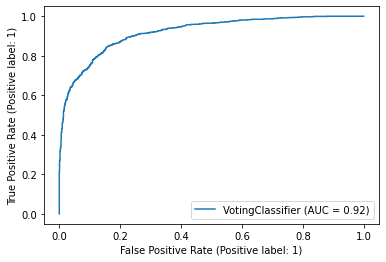

In [37]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

clf1 = RandomForestClassifier(n_estimators=200, class_weight={0: 100, 1: 1})
clf2 = GradientBoostingClassifier(n_estimators=1000, max_depth=7)
clf3 = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})
clf4 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)
pos_clf = VotingClassifier(estimators=[('pos', clf1), ('gb', clf2),
                                        ('et', clf3), ('xgb', clf4)],
                            voting='soft',
                            weights=[1, 2, 1, 1])

pos_clf.fit(X_train, Y_train)

#Prediction
Vot_modelprediction=pos_clf.predict(X_test)

evaluate_model (pos_clf, X_test, y_test, Vot_modelprediction)

**Gradient Boosting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8340996168582375
2. confusion_matrix:
[[1056  241]
 [ 192 1121]]
3. recall_score:  0.8537699923838538
4. precision_score:  0.8230543318649045
5. f1_score:  0.8381308411214952
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


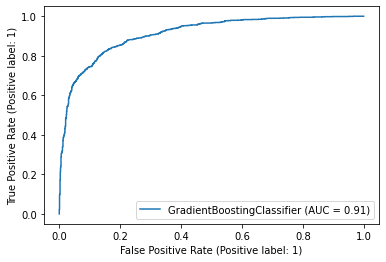

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

GBoost = GradientBoostingClassifier(n_estimators=1000, max_depth=7)


GBoost.fit(X_train, Y_train)

#Prediction
GBoost_modelprediction=GBoost.predict(X_test)

evaluate_model (GBoost, X_test, y_test, GBoost_modelprediction)

**Extra Trees Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8172413793103448
2. confusion_matrix:
[[1099  328]
 [ 149 1034]]
3. recall_score:  0.8740490278951818
4. precision_score:  0.7591776798825257
5. f1_score:  0.812573673870334
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


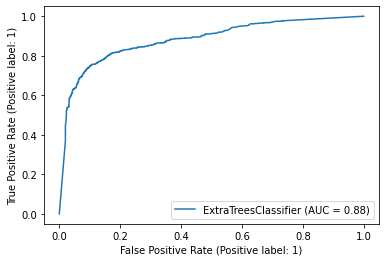

In [39]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

Extra = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})


Extra.fit(X_train, Y_train)

#Prediction
Extra_modelprediction=Extra.predict(X_test)

evaluate_model (Extra, X_test, y_test, Extra_modelprediction)

**Cat Boosting**

In [40]:
# pip install catboost

0:	learn: 0.6613562	total: 59.3ms	remaining: 59.3s
1:	learn: 0.6337067	total: 69.3ms	remaining: 34.6s
2:	learn: 0.6163864	total: 77.7ms	remaining: 25.8s
3:	learn: 0.5989057	total: 86.3ms	remaining: 21.5s
4:	learn: 0.5831416	total: 94.9ms	remaining: 18.9s
5:	learn: 0.5692779	total: 104ms	remaining: 17.2s
6:	learn: 0.5554844	total: 112ms	remaining: 15.9s
7:	learn: 0.5465455	total: 120ms	remaining: 14.9s
8:	learn: 0.5372219	total: 128ms	remaining: 14.1s
9:	learn: 0.5270038	total: 136ms	remaining: 13.5s
10:	learn: 0.5212862	total: 145ms	remaining: 13s
11:	learn: 0.5149138	total: 152ms	remaining: 12.5s
12:	learn: 0.5086872	total: 160ms	remaining: 12.2s
13:	learn: 0.5039034	total: 169ms	remaining: 11.9s
14:	learn: 0.4988641	total: 179ms	remaining: 11.8s
15:	learn: 0.4940374	total: 187ms	remaining: 11.5s
16:	learn: 0.4907496	total: 195ms	remaining: 11.3s
17:	learn: 0.4841206	total: 202ms	remaining: 11s
18:	learn: 0.4790956	total: 210ms	remaining: 10.8s
19:	learn: 0.4727099	total: 217ms	remain

182:	learn: 0.3026023	total: 1.46s	remaining: 6.5s
183:	learn: 0.3017962	total: 1.47s	remaining: 6.51s
184:	learn: 0.3016543	total: 1.48s	remaining: 6.5s
185:	learn: 0.3014086	total: 1.48s	remaining: 6.49s
186:	learn: 0.3007967	total: 1.49s	remaining: 6.48s
187:	learn: 0.3007925	total: 1.5s	remaining: 6.47s
188:	learn: 0.3007891	total: 1.5s	remaining: 6.46s
189:	learn: 0.2999420	total: 1.51s	remaining: 6.45s
190:	learn: 0.2998730	total: 1.52s	remaining: 6.44s
191:	learn: 0.2997729	total: 1.53s	remaining: 6.43s
192:	learn: 0.2989081	total: 1.53s	remaining: 6.42s
193:	learn: 0.2982598	total: 1.54s	remaining: 6.41s
194:	learn: 0.2979424	total: 1.55s	remaining: 6.4s
195:	learn: 0.2973096	total: 1.56s	remaining: 6.38s
196:	learn: 0.2968808	total: 1.56s	remaining: 6.37s
197:	learn: 0.2961869	total: 1.57s	remaining: 6.37s
198:	learn: 0.2961644	total: 1.58s	remaining: 6.35s
199:	learn: 0.2959949	total: 1.58s	remaining: 6.34s
200:	learn: 0.2953407	total: 1.59s	remaining: 6.33s
201:	learn: 0.295

359:	learn: 0.2504071	total: 2.85s	remaining: 5.08s
360:	learn: 0.2500627	total: 2.87s	remaining: 5.07s
361:	learn: 0.2497328	total: 2.88s	remaining: 5.07s
362:	learn: 0.2495534	total: 2.88s	remaining: 5.06s
363:	learn: 0.2491118	total: 2.89s	remaining: 5.05s
364:	learn: 0.2488661	total: 2.9s	remaining: 5.05s
365:	learn: 0.2484767	total: 2.91s	remaining: 5.04s
366:	learn: 0.2479120	total: 2.92s	remaining: 5.03s
367:	learn: 0.2476984	total: 2.92s	remaining: 5.02s
368:	learn: 0.2473287	total: 2.93s	remaining: 5.01s
369:	learn: 0.2468684	total: 2.94s	remaining: 5.01s
370:	learn: 0.2466802	total: 2.95s	remaining: 5s
371:	learn: 0.2461972	total: 2.96s	remaining: 4.99s
372:	learn: 0.2457636	total: 2.96s	remaining: 4.98s
373:	learn: 0.2454980	total: 2.97s	remaining: 4.98s
374:	learn: 0.2451710	total: 2.98s	remaining: 4.97s
375:	learn: 0.2448609	total: 2.99s	remaining: 4.96s
376:	learn: 0.2447465	total: 3s	remaining: 4.95s
377:	learn: 0.2446844	total: 3s	remaining: 4.95s
378:	learn: 0.2446514	

518:	learn: 0.2247819	total: 4.05s	remaining: 3.75s
519:	learn: 0.2245677	total: 4.06s	remaining: 3.75s
520:	learn: 0.2244085	total: 4.07s	remaining: 3.74s
521:	learn: 0.2243566	total: 4.08s	remaining: 3.73s
522:	learn: 0.2243104	total: 4.08s	remaining: 3.72s
523:	learn: 0.2241928	total: 4.09s	remaining: 3.71s
524:	learn: 0.2241862	total: 4.1s	remaining: 3.71s
525:	learn: 0.2237471	total: 4.11s	remaining: 3.7s
526:	learn: 0.2237249	total: 4.11s	remaining: 3.69s
527:	learn: 0.2234595	total: 4.12s	remaining: 3.68s
528:	learn: 0.2232852	total: 4.13s	remaining: 3.67s
529:	learn: 0.2230812	total: 4.14s	remaining: 3.67s
530:	learn: 0.2228941	total: 4.14s	remaining: 3.66s
531:	learn: 0.2227582	total: 4.15s	remaining: 3.65s
532:	learn: 0.2223778	total: 4.16s	remaining: 3.65s
533:	learn: 0.2222945	total: 4.17s	remaining: 3.64s
534:	learn: 0.2222134	total: 4.17s	remaining: 3.63s
535:	learn: 0.2222129	total: 4.18s	remaining: 3.62s
536:	learn: 0.2220699	total: 4.19s	remaining: 3.61s
537:	learn: 0.

685:	learn: 0.2024497	total: 5.67s	remaining: 2.59s
686:	learn: 0.2022840	total: 5.67s	remaining: 2.58s
687:	learn: 0.2021305	total: 5.68s	remaining: 2.58s
688:	learn: 0.2019190	total: 5.69s	remaining: 2.57s
689:	learn: 0.2018146	total: 5.7s	remaining: 2.56s
690:	learn: 0.2016364	total: 5.71s	remaining: 2.56s
691:	learn: 0.2014256	total: 5.72s	remaining: 2.55s
692:	learn: 0.2013149	total: 5.73s	remaining: 2.54s
693:	learn: 0.2012355	total: 5.74s	remaining: 2.53s
694:	learn: 0.2011904	total: 5.75s	remaining: 2.52s
695:	learn: 0.2009743	total: 5.76s	remaining: 2.52s
696:	learn: 0.2009212	total: 5.77s	remaining: 2.51s
697:	learn: 0.2008061	total: 5.78s	remaining: 2.5s
698:	learn: 0.2007911	total: 5.79s	remaining: 2.49s
699:	learn: 0.2007714	total: 5.79s	remaining: 2.48s
700:	learn: 0.2007108	total: 5.8s	remaining: 2.47s
701:	learn: 0.2005432	total: 5.81s	remaining: 2.47s
702:	learn: 0.2003851	total: 5.82s	remaining: 2.46s
703:	learn: 0.2003850	total: 5.83s	remaining: 2.45s
704:	learn: 0.2

844:	learn: 0.1863855	total: 7.05s	remaining: 1.29s
845:	learn: 0.1863071	total: 7.07s	remaining: 1.29s
846:	learn: 0.1862907	total: 7.08s	remaining: 1.28s
847:	learn: 0.1862907	total: 7.09s	remaining: 1.27s
848:	learn: 0.1862442	total: 7.1s	remaining: 1.26s
849:	learn: 0.1862377	total: 7.12s	remaining: 1.26s
850:	learn: 0.1862007	total: 7.14s	remaining: 1.25s
851:	learn: 0.1861504	total: 7.16s	remaining: 1.24s
852:	learn: 0.1861282	total: 7.17s	remaining: 1.24s
853:	learn: 0.1861064	total: 7.19s	remaining: 1.23s
854:	learn: 0.1860338	total: 7.2s	remaining: 1.22s
855:	learn: 0.1858350	total: 7.21s	remaining: 1.21s
856:	learn: 0.1856894	total: 7.22s	remaining: 1.21s
857:	learn: 0.1856795	total: 7.24s	remaining: 1.2s
858:	learn: 0.1854985	total: 7.25s	remaining: 1.19s
859:	learn: 0.1854244	total: 7.27s	remaining: 1.18s
860:	learn: 0.1854243	total: 7.28s	remaining: 1.17s
861:	learn: 0.1852622	total: 7.29s	remaining: 1.17s
862:	learn: 0.1852599	total: 7.29s	remaining: 1.16s
863:	learn: 0.1

/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


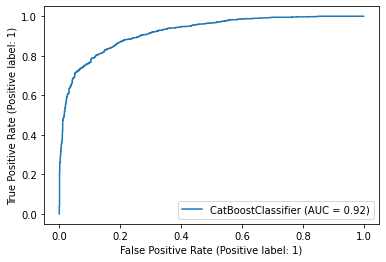

In [41]:
from catboost import CatBoostClassifier

model_catboss = CatBoostClassifier(learning_rate = 0.1, depth = 8, rsm = 1)

model_catboss.fit(X_train, Y_train)

#Prediction
cast_modelprediction=model_catboss.predict(X_test)

evaluate_model (model_catboss, X_test, y_test, cast_modelprediction)

# **Deep Learning**

# **ANN**

In [63]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [64]:
# Create a Sequential Neural Network model 
model = Sequential()
# Create an Input and a Hidden Layer
model.add(Dense(units=50,activation="relu",kernel_initializer="he_uniform"))
# Create an Output Layer
model.add(Dense(units=1,activation="sigmoid"))
# Now, my model is ready to compile
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [65]:
model.fit(X_train,y_train,batch_size=64,epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 10436
  y sizes: 9132
Make sure all arrays contain the same number of samples.

In [66]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
# Predict the X_test results
y_pred = model.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# **LSTM**

In [ ]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dropout

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
regressor.summary()

In [ ]:
# Predict the X_test results
y_pred = regressor.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# ***Kết thúc!***